In [0]:
%%capture

!pip install minisom
!pip install spotipy

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import pickle
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# kaggle data loaded from github repo

songs = pd.read_csv('https://raw.githubusercontent.com/Jllin50/DS/master/data/song_data.csv')
song_info = pd.read_csv('https://raw.githubusercontent.com/Jllin50/DS/master/data/song_info.csv')

In [4]:
songs.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


#PREP DATA

In [0]:
songs = songs.rename(columns={'audio_valence': 'valence'})

In [0]:
songs.insert(loc=1, column='song_artist', value=song_info['artist_name'])

In [0]:
songs = songs.drop(labels=['song_popularity', 'song_duration_ms', 'key', 'audio_mode'], axis=1)

In [0]:
songs = songs.drop_duplicates(subset=['song_name', 'song_artist'])

In [9]:
#rearranging the columns
cols = ['song_name', 'song_artist', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
songs = songs[cols]
songs.columns

Index(['song_name', 'song_artist', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [0]:
features = songs.drop(labels=['song_name', 'song_artist'], axis=1)

In [0]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [0]:
songs_scaled = songs.join(pd.DataFrame(features_scaled)).drop(
    labels=features.columns, axis=1)

songs_scaled = songs_scaled.rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

In [0]:
songs_scaled = songs_scaled.dropna()

In [14]:
songs_scaled

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Boulevard of Broken Dreams,Green Day,0.502533,0.682342,0.859242,0.031243,0.005541,0.000029,0.049226,0.481707,0.689425,0.8
1,In The End,Linkin Park,0.549139,0.853697,0.801948,0.052922,0.010340,0.000000,0.099580,0.376016,0.434371,0.8
2,Seven Nation Army,The White Stripes,0.746707,0.462888,0.766734,0.084166,0.008202,0.448345,0.250333,0.329268,0.511233,0.8
3,By The Way,Red Hot Chili Peppers,0.456940,0.970940,0.838352,0.113709,0.026505,0.003561,0.093426,0.201220,0.505303,0.8
4,How You Remind Me,Nickelback,0.452888,0.766517,0.835204,0.033262,0.000957,0.000000,0.104707,0.583333,0.709856,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
13999,Replay,Zendaya,0.374873,0.135210,0.625480,0.046015,0.901606,0.000264,0.091273,0.060163,0.602848,0.8
14000,Where Are Ü Now (with Justin Bieber),Jack Ü,0.652482,0.523013,0.770897,0.040170,0.396586,0.000000,0.084196,0.452236,0.396033,0.8
14001,The Heart Wants What It Wants,Selena Gomez,0.506586,0.150241,0.561569,0.036982,0.896586,0.000066,0.102656,0.304878,0.470328,0.8
14002,Thotful,Cody Simpson,0.501520,0.160262,0.611850,0.031987,0.768072,0.000001,0.096503,0.269309,0.389100,0.8


# kmeans

In [0]:

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_scaled)
    Sum_of_squared_distances.append(km.inertia_)

In [16]:
from sklearn.metrics import silhouette_score

# Alternative scoring to elbow plot

for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(features_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (features_scaled, preds, metric='euclidean')
    print (f'n_clusters = {n_clusters}, silhouette score = {score})')

n_clusters = 2, silhouette score = 0.3305319775222961)
n_clusters = 3, silhouette score = 0.3031183585447442)
n_clusters = 4, silhouette score = 0.21299936715035422)
n_clusters = 5, silhouette score = 0.22913173496939226)
n_clusters = 6, silhouette score = 0.21388880975655164)
n_clusters = 7, silhouette score = 0.20393966926310061)
n_clusters = 8, silhouette score = 0.20605599306706285)
n_clusters = 9, silhouette score = 0.18341771266118848)
n_clusters = 10, silhouette score = 0.18672140474020665)
n_clusters = 11, silhouette score = 0.16436836763542362)
n_clusters = 12, silhouette score = 0.15515517641392831)
n_clusters = 13, silhouette score = 0.153743255279205)
n_clusters = 14, silhouette score = 0.1471275286812563)


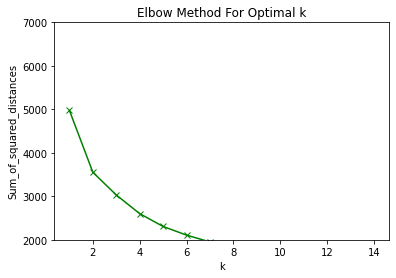

In [17]:
# elbow plot

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.ylim(2000, 7000)
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
# setting for reproducibility

np.random.seed(42)

# implementing kmeans

kmeans = KMeans(n_clusters=7)
kmeans.fit(features_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# pulling cluster labels from kmeans
y_kmeans = kmeans.predict(features_scaled)

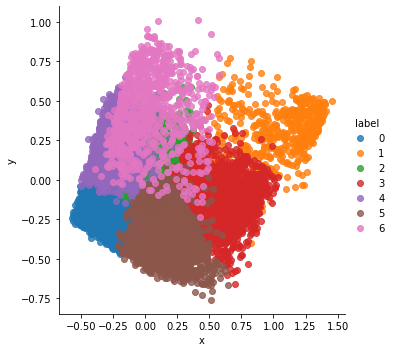

In [20]:
# pca to project into 2-D

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# plotting clusters

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

### Visualizing clusters using t-distributed Stochastic Neighbor Embedding

In [24]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-2, n_iter=250, verbose=1)

tsne_components = tsne.fit_transform(features_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14006 samples in 0.030s...
[t-SNE] Computed neighbors for 14006 samples in 2.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14006
[t-SNE] Computed conditional probabilities for sample 2000 / 14006
[t-SNE] Computed conditional probabilities for sample 3000 / 14006
[t-SNE] Computed conditional probabilities for sample 4000 / 14006
[t-SNE] Computed conditional probabilities for sample 5000 / 14006
[t-SNE] Computed conditional probabilities for sample 6000 / 14006
[t-SNE] Computed conditional probabilities for sample 7000 / 14006
[t-SNE] Computed conditional probabilities for sample 8000 / 14006
[t-SNE] Computed conditional probabilities for sample 9000 / 14006
[t-SNE] Computed conditional probabilities for sample 10000 / 14006
[t-SNE] Computed conditional probabilities for sample 11000 / 14006
[t-SNE] Computed conditional probabilities for sample 12000 / 14006
[t-SNE] Computed conditional probabilities for sam

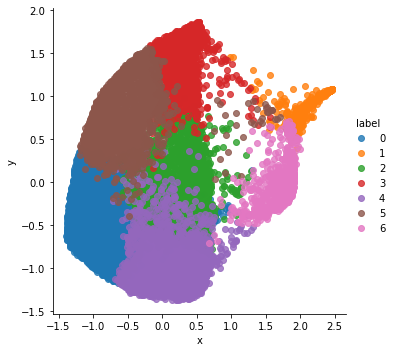

In [25]:
# plotting clusters

ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

# Predict labels with neural net

In [26]:
songs['label'] = y_kmeans

songs = songs.sample(frac=1)
songs['label'].value_counts()

0    3802
2    2698
4    2611
5    1836
3    1657
6     823
1     579
Name: label, dtype: int64

In [27]:
songs[songs['label'] == 6].sample(3)

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label
3122,B Cool (feat. Melanie Faye),Magroove,0.794,0.368,-12.725,0.0523,0.5590,0.694,0.0864,0.775,140.063,4,6
18041,Sleep,Bicurious,0.486,0.815,-4.923,0.0391,0.0703,0.726,0.1760,0.611,104.592,4,6
6126,Triple Darkness,Scan 7,0.721,0.883,-12.631,0.0340,0.0207,0.875,0.0855,0.586,138.007,4,6


### Data Prep and Model Building

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_kmeans, test_size=0.2)

y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [29]:
model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

inputs = Input(shape=(10,))

model.summary()

model.compile('nadam', 'categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 231       
Total params: 11,975
Trainable params: 11,975
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train, y_train_binary, epochs=100, batch_size=16, validation_split=.2)

Epoch 1/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9681 - val_loss: 0.1010 - val_accuracy: 0.9576
Epoch 2/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0740 - accuracy: 0.9689 - val_loss: 0.1092 - val_accuracy: 0.9549
Epoch 3/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0681 - accuracy: 0.9719 - val_loss: 0.1683 - val_accuracy: 0.9389
Epoch 4/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0652 - accuracy: 0.9723 - val_loss: 0.0609 - val_accuracy: 0.9781
Epoch 5/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0654 - accuracy: 0.9746 - val_loss: 0.0736 - val_accuracy: 0.9692
Epoch 6/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0667 - accuracy: 0.9730 - val_loss: 0.1406 - val_accuracy: 0.9482
Epoch 7/100
561/561 [==============================] - 1s 2ms/step - loss: 0.0630 - accuracy: 0.9731 - val_loss: 0.0804 - val_accuracy: 0.9630

In [33]:
# model evaluates well on test set - 95.7 %!!!

model.evaluate(X_test, y_test_binary)

88/88 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9579


[0.11958218365907669, 0.9578872323036194]

**Predicting from API**

In [0]:
# credentials

client_credentials_manager = SpotifyClientCredentials(client_id='f13a6b55c2d949939455644bbd6f31d9', client_secret='c7c009270ff0483db51d25543563d55c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [35]:
# pulling a track from a playlist

playlist = sp.playlist('open.spotify.com/playlist/2YRe7HRKNRvXdJBp9nXFza')

track_info = dict(song=playlist['tracks']['items'][2]['track']['name'], 
                  artist=playlist['tracks']['items'][2]['track']['album']['artists'][0]['name'],
                  uri=playlist['tracks']['items'][2]['track']['uri'])

track_info

{'artist': 'Drake',
 'song': 'One Dance',
 'uri': 'spotify:track:12VWzyPDBCc8fqeWCAfNwR'}

In [36]:
# pulling audio features for selected track

track_features = sp.audio_features(track_info['uri'])

track_features

[{'acousticness': 0.00776,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/12VWzyPDBCc8fqeWCAfNwR',
  'danceability': 0.792,
  'duration_ms': 173987,
  'energy': 0.625,
  'id': '12VWzyPDBCc8fqeWCAfNwR',
  'instrumentalness': 0.00188,
  'key': 1,
  'liveness': 0.329,
  'loudness': -5.609,
  'mode': 1,
  'speechiness': 0.0536,
  'tempo': 103.967,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/12VWzyPDBCc8fqeWCAfNwR',
  'type': 'audio_features',
  'uri': 'spotify:track:12VWzyPDBCc8fqeWCAfNwR',
  'valence': 0.37}]

In [37]:
# trimming to only relevant features

track = [track_features[0][i] for i in features]

track

[0.792, 0.625, -5.609, 0.0536, 0.00776, 0.00188, 0.329, 0.37, 103.967, 4]

In [0]:
# scaling for NN

track_scaled = scaler.transform(np.array(track).reshape(1, -1))

## Song Suggestion by euclidean distance

In addition to the clustering, we can treat the normalized features themselves as two series representing points and compute the distance between them in euclidean space - the closer together, the more similar they are. 

Across clusters I'm not sure how indicative of similarity this is, but within clusters it seems to work well.

I think we may be able to put some human compute power into investigating the clusters; my feeling is that we can probably associate moods or energy with them.

In [0]:
# filtering songs by predicted label of sample track

songs = songs.sort_index()

filtered_songs = songs[songs['label'] == model.predict_classes(track_scaled)[0]]

In [0]:
# dropping unnecessary columns and renaming for readability

songs_scaled = filtered_songs.join(pd.DataFrame(features_scaled)).drop(
    labels=features.columns, axis=1)

songs_scaled = songs_scaled.rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

In [0]:
# computing distance from sample track for each track in cluster

songs_scaled['distance'] = [(np.linalg.norm(
    songs_scaled[features.columns][i:i+1] - track_scaled)) 
                         for i in range(0, len(songs_scaled))]

# filtering to only songs within a certain distance

neighbors = songs_scaled[songs_scaled['distance'] < .2].sort_values('distance')

In [0]:
# prepping to create results array

track_scaled = pd.DataFrame(track_scaled).rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

In [0]:
# rejoining artist and title with song features

results = pd.DataFrame(track_info, 
                       index=[0], 
                       columns=['song', 'artist']
                      ).rename(columns={'song': 'song_name',
                                        'artist': 'song_artist'}
                              )

results = pd.concat([results, track_scaled], axis=1)

results['label'] = model.predict_classes(track_scaled)

# adding sample track to filtered songs

results = pd.concat([results, neighbors])

# dropping duplicates where name and artist are identical

results = results.drop_duplicates(subset=['song_name', 'song_artist'])

In [0]:
result_df = pd.concat([results[:1], results.sample(6).sort_values('distance')])

In [47]:
result_df

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label,distance
0,One Dance,Drake,0.802432,0.625224,0.821723,0.056961,0.007790,0.001886,0.326223,0.376016,0.429052,0.8,2,NaN
8638,Black Beatles,Rae Sremmurd,0.758865,0.717415,0.803162,0.084697,0.022790,0.000000,0.258538,0.406504,0.433179,0.8,2,0.131406
10554,Lucy,Cuco,0.824721,0.676330,0.762645,0.037088,0.030822,0.011434,0.374423,0.313008,0.503425,0.8,2,0.139428
70,Wake Up in the Sky,Gucci Mane,0.810537,0.578127,0.833247,0.051541,0.003824,0.000000,0.356989,0.372967,0.590175,0.8,2,0.171411
6519,Million Reasons,Lady Gaga,0.764944,0.575120,0.752757,0.071520,0.044477,0.001274,0.271870,0.501016,0.354881,0.8,2,0.185232
3709,PICK IT UP (feat. A$AP Rocky),Famous Dex,0.842958,0.686351,0.826779,0.168969,0.012248,0.000000,0.331351,0.487805,0.507383,0.8,2,0.191396
0,One Dance,Drake,0.802432,0.625224,0.821723,0.056961,0.007790,0.001886,0.326223,0.376016,0.429052,0.8,2,NaN


### Random Song Suggestion Based On Sample Track

In [48]:
results.sample(1)

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label,distance
0,One Dance,Drake,0.802432,0.625224,0.821723,0.056961,0.00779,0.001886,0.326223,0.376016,0.429052,0.8,2,NaN


### Sample Track + All Tracks In Cluster, By Distance

In [49]:
pd.concat([results[:1], results.sort_values('distance')[:-1]])

,song_name,song_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label,distance
0,One Dance,Drake,0.802432,0.625224,0.821723,0.056961,0.007790,0.001886,0.326223,0.376016,0.429052,0.8,2,NaN
8638,Black Beatles,Rae Sremmurd,0.758865,0.717415,0.803162,0.084697,0.022790,0.000000,0.258538,0.406504,0.433179,0.8,2,0.131406
10554,Lucy,Cuco,0.824721,0.676330,0.762645,0.037088,0.030822,0.011434,0.374423,0.313008,0.503425,0.8,2,0.139428
70,Wake Up in the Sky,Gucci Mane,0.810537,0.578127,0.833247,0.051541,0.003824,0.000000,0.356989,0.372967,0.590175,0.8,2,0.171411
7697,Розовое вино,Allj,0.875380,0.631237,0.785741,0.109458,0.024296,0.000000,0.183673,0.369919,0.454176,0.8,2,0.175137
6519,Million Reasons,Lady Gaga,0.764944,0.575120,0.752757,0.071520,0.044477,0.001274,0.271870,0.501016,0.354881,0.8,2,0.185232
3709,PICK IT UP (feat. A$AP Rocky),Famous Dex,0.842958,0.686351,0.826779,0.168969,0.012248,0.000000,0.331351,0.487805,0.507383,0.8,2,0.191396
9343,Blood Diamonds,The Game,0.766971,0.672322,0.799048,0.101488,0.018674,0.000000,0.150856,0.388211,0.462186,0.8,2,0.195178
100,Don't Werk,Paula DeAnda,0.712259,0.617208,0.744331,0.077683,0.108433,0.000056,0.266742,0.442073,0.508254,0.8,2,0.197284


In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Input, Dense, Activation
import json

#Loading and preparing the data

# kaggle data loaded from github repo
songs = pd.read_csv('https://raw.githubusercontent.com/Jllin50/DS/master/data/song_data.csv')
song_info = pd.read_csv('https://raw.githubusercontent.com/Jllin50/DS/master/data/song_info.csv')

#cleaning songs df
songs = songs.rename(columns={'audio_valence': 'valence'})
songs.insert(loc=1, column='song_artist', value=song_info['artist_name'])
songs = songs.drop(labels=['song_popularity', 'song_duration_ms', 'key', 'audio_mode'], axis=1)
cols = ['song_name', 'song_artist', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
songs = songs[cols]

#creating a scaled features df from the song df
features = songs.drop(labels=['song_name', 'song_artist'], axis=1)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# implementing kmeans
np.random.seed(42)
kmeans = KMeans(n_clusters=7)
kmeans.fit(features_scaled)

#cluster predictions for each song
y_kmeans = kmeans.predict(features_scaled)

#adding song kmean group label to song df 
songs['label'] = y_kmeans
songs = songs.sample(frac=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_kmeans, test_size=0.2)

y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

# #neural network
model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

inputs = Input(shape=(10,))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_binary, epochs=10, batch_size=16, validation_split=.2)

Epoch 1/10
754/754 [==============================] - 2s 2ms/step - loss: 0.4441 - accuracy: 0.8537 - val_loss: 0.1837 - val_accuracy: 0.9287
Epoch 2/10
754/754 [==============================] - 1s 2ms/step - loss: 0.1584 - accuracy: 0.9386 - val_loss: 0.1865 - val_accuracy: 0.9107
Epoch 3/10
754/754 [==============================] - 1s 2ms/step - loss: 0.1321 - accuracy: 0.9496 - val_loss: 0.1117 - val_accuracy: 0.9599
Epoch 4/10
754/754 [==============================] - 1s 2ms/step - loss: 0.1130 - accuracy: 0.9549 - val_loss: 0.1273 - val_accuracy: 0.9423
Epoch 5/10
754/754 [==============================] - 1s 2ms/step - loss: 0.1117 - accuracy: 0.9531 - val_loss: 0.0877 - val_accuracy: 0.9658
Epoch 6/10
754/754 [==============================] - 1s 2ms/step - loss: 0.1048 - accuracy: 0.9564 - val_loss: 0.0928 - val_accuracy: 0.9622
Epoch 7/10
754/754 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9598 - val_loss: 0.1049 - val_accuracy: 0.9545
Epoch 

In [0]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [0]:
#main function
def take_ten(a_list):
  '''takes input list for 1 song and returns a json file with the 10 most similar songs''' 
  global track_info

  #setting static variables for results_dataframe function
  input_scaled = np.empty((1,10))
  track_info = dict({'artist': a_list[1], 'song': a_list[0]})

  #saving results as json
  results_df = results_dataframe(find_neighbors(scaled_songs(adj_input(a_list))))[['song_name', 'song_artist']]
  results_df.to_json('results.json', orient='records')
  with open('results.json') as json_file:
    json_data = json.load(json_file)

  return json_data

In [0]:
#sub functions
def adj_input(the_list):
    '''takes an input list and returns cleaned and scaled version'''
    global a_list

    a_list = the_list
    input_vector = a_list[2:]
    input_scaled = scaler.transform(np.array(input_vector).reshape(1, -1))
    return input_scaled

def scaled_songs(a_array):
    '''takes scaled input array and returns a df with scaled values'''
    global songs
    
    #filtering songs by predicted label of sample track
    songs = songs.sort_index()

    filtered_songs = songs[songs['label'] == model.predict_classes(a_array)[0]]

    # dropping unnecessary columns and renaming for readability

    songs_scaled = filtered_songs.join(pd.DataFrame(features_scaled)).drop(
    labels=features.columns, axis=1)

    songs_scaled = songs_scaled.rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

    return songs_scaled 

def find_neighbors(a_df):
    '''takes scaled df and returns df filtered for songs near to sample '''
    global a_list

    # computing distance from sample track for each track in cluster

    a_df['distance'] = [(np.linalg.norm(
    a_df[features.columns][i:i+1] - adj_input(a_list))) 
    for i in range(0, len(a_df))]

    # filtering to only songs within a certain distance

    neighbors = a_df[a_df['distance'] < .2].sort_values('distance')

    return neighbors

def results_dataframe(neighbors):

    # turning input scaled to df
    global input_scaled
    global track_info

    # neighbors = find_neighbors(scaled_songs(adj_input(a_list)))

    input_scaled = pd.DataFrame(adj_input(a_list)).rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

    # rejoining artist and title with song features

    results = pd.DataFrame(track_info, 
                       index=[0], 
                       columns=['song', 'artist']
                      ).rename(columns={'song': 'song_name',
                                        'artist': 'song_artist'}
                              )

    results = pd.concat([results, input_scaled], axis=1)

    results['label'] = model.predict_classes(input_scaled)
    
    # adding sample track to filtered songs

    results = pd.concat([results, neighbors])

    # dropping duplicates where name and artist are identical

    results = results.drop_duplicates(subset=['song_name', 'song_artist'])

    #return top 10 song names with artist
    result_df = pd.concat([results[:1], results.sample(10).sort_values('distance')])

    result_df = result_df[['song_name','song_artist']]

    result_df = pd.concat([results[:1], results.sample(10).sort_values('distance')])

    return result_df

In [0]:
#example use 
the_list = ['rockstar (feat. 21 Savage)', 'Post Malone', 0.585, 0.52, -6.136, 0.0712, 0.124, 7.01e-05, 0.131, 0.129, 159.801, 4]

In [55]:
print(take_ten(the_list))

[{'song_name': 'rockstar (feat. 21 Savage)', 'song_artist': 'Post Malone'}, {'song_name': 'Us Ft. Lil Peep & Lil Tracy', 'song_artist': 'SinceWhen'}, {'song_name': 'Chains', 'song_artist': 'Nick Jonas'}, {'song_name': 'Just Say When (Version 2.0)', 'song_artist': 'Nothing More'}, {'song_name': 'Dancing Shoes', 'song_artist': 'Green River Ordinance'}, {'song_name': 'I Believe in a Thing Called Love', 'song_artist': 'Branches'}, {'song_name': 'Sky Walker', 'song_artist': 'Miguel'}, {'song_name': 'Tu No Eres Ganga', 'song_artist': 'Lito Kirino'}, {'song_name': 'Cold Showers', 'song_artist': 'Chelsea Cutler'}, {'song_name': 'Silver Lining', 'song_artist': 'Mt. Joy'}, {'song_name': 'Somebody That I Used to Know', 'song_artist': 'Pentatonix'}]
